# Clone image loader and install it

In [11]:
!git clone https://github.com/lanalex/image_loader.git
!cd ./image_loader && python3 setup.py install

fatal: destination path 'image_loader' already exists and is not an empty directory.
running install
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/setuptools/command/easy_install.py:147: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
writing seedoo.egg-info/PKG-INFO
writing dependency_links to seedoo.egg-info/dependency_links.txt
writing top-level names to seedoo.egg-info/top_level.txt
reading manifest file 'seedoo.egg-info/SOURCES.txt'
writing manifest file 'seedoo.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/

In [56]:
# Unpack the data

# Copy the data from s3

In [28]:
!aws s3 cp s3://seedoopublic/data.zip ./data.zip

download: s3://seedoopublic/data.zip to ./data.zip                  


In [ ]:

!unzip ./data.zip -d ./data


# Install fastdup


In [14]:
!pip3 install fastdup

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# Lets import the ImageLoader so we can visualize 

In [11]:
import sys

# Not mandatory but on AWS Sage the editable isntall seems not work 
sys.path.append("./image_loader")

from seedoo.vision.utils.image_loading import ImageLoader, ListOfImageLoaders


# Lets run fastdup to get the components CSV 
> Efficnet high scaling clustering
> We use the ReID network from https://github.com/KaiyangZhou/deep-person-reid as ONNX to extract the features. We use the last layer before the fully connected layer
> we found that his gives better performance. In general our experimination shows that a task oriented embedding provides better results than a generic embedding


In [12]:
import fastdup
work_dir = 'reid-mobilenet'

fastdup.run(
    input_dir="./data/images/", 
    work_dir=work_dir, 
    turi_param='ccthreshold=0.99',
    threshold=0.9,
    num_images=19000,
    model_path='./MobileNetV2_3_300_170.onnx',
    d=1280,
)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
Going to loop over dir data/images/
Found total 19000 images to run on
Found total 19000 images to run on■■■■■■■■■■■■■■■■■] 100% Estimated: 0 Minutes 0 Features6% Estimated: 1 Minutes 0 Features
6782) Finished write_index() NN model
Stored nn model index file reid-mobilenet/nnf.index
Total time took 132329 ms
Found a total of 381 fully identical images (d>0.990), which are 0.67 %
Found a total of 3024 nearly identical images(d>0.980), which are 5.31 %
Found a total of 34862 above threshold images (d>0.900), which are 61.16 %
Found a total of 1900 outlier images         (d<0.050), which are 3.33 %
Min distance found 0.765 max distance 1.000
1678204957 : INFO:     (add_vertices:460): Num vertices for group 0: 19000
1678204957 : INFO:     (commit_edge_buffer:609): In commit edge buffer (0,0)
1678204957 : INFO:     (commit_edge_buffer:680): Shuffling edges ...
1678204957 : INFO:     (commit_edge_buffer:688): Done sh

0

# Since we are dealing with a multi label problem, 
> we also use fastdups ability to pass a callback to read the label of a sample, without the need to specify it a

In [13]:
import os
import pandas as pd
from tqdm import tqdm_notebook

labels_index = {} 

path = 'data/images'

peta = pd.read_csv('./data/peta.csv')
peta['image_path'] = peta['image_path'].apply(lambda x: os.path.join(path, os.path.basename(x)))




# read all labels to create a pandas dataframe with list of labels per image
def get_label_list(daraframe):
    lines = []
    index = []
    filename = []
    name = []
    for i, row in tqdm_notebook(daraframe.iterrows()):
        lines.append(list(eval(row.attributes).keys()))
        index.append(i)
        filename.append(row.image_path)
        name = os.path.basename(row.image_path)
        labels_index[row.image_path] = lines[-1]
    return pd.DataFrame({'index':index, 'labels':lines, 'file':filename, 'name':name})

# This is the callback fastdup calls. Given a filename, return the labels
def get_label(fname):
    """label extractor for create_components_gallery"""
    return labels_index[fname]

    
# Initialize the labels index
labels = get_label_list(peta)


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

# Now lets create the components library with fastdup (clustering) 

Failed to read config file ./config.json
['personalLess45', 'carryingOther', 'lowerBodyFormal', 'upperBodyFormal', 'footwearLeatherShoes', 'personalMale', 'accessoryNothing', 'lowerBodyTrousers', 'upperBodyBlack', 'lowerBodyGrey', 'hairBlack', 'footwearBlack', 'upperBodyLongSleeve', 'hairShort', 'upperBodySweater']


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Finished OK. Components are stored as image files reid-mobilenet/components_gallery/components_[index].jpg
Stored components visual view in  reid-mobilenet/components_gallery/components.html
Execution time in seconds 23.2


0

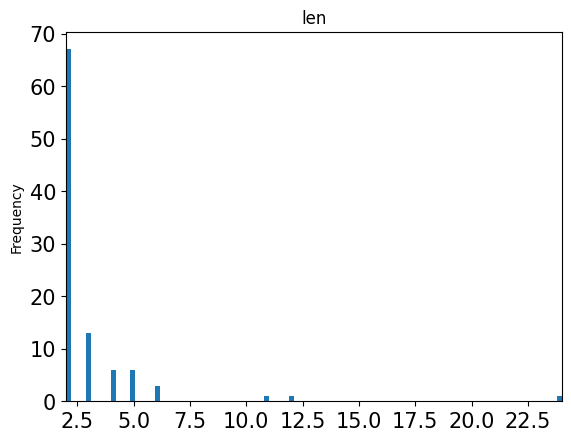

In [14]:



for index, row in labels.iterrows():
    labels_index[row.file] = row.labels


# create components dataframe for component_generator
top_components = fastdup.find_top_components(work_dir)
N_TOP_COMPONENTS = top_components.shape[0]

# crete gallery
fastdup.create_components_gallery(work_dir=work_dir,
                                  save_path=f'{work_dir}/components_gallery', 
                                  get_label_func=get_label, 
                                  num_images=N_TOP_COMPONENTS,
                                  max_width=300, 
                                  save_artifacts=True,
                                  lazy_load=True
                                 )


## Image Label Cleaning

In this step, we aim to develop a mechanism to identify and remove bad labels and groups of images. The process involves the following steps:

1. Creation of various functions that accept a group of images and their label counts.

2. The functions return a new column for each of the methods used to identify good and bad images.

3. A list of clean labels is returned for each row.

The result is a single DataFrame with several columns representing the output of different algorithms for cleaning. These columns can then be used to filter the data using `df.query` to run different experiments and determine the best cleaning method.


## The various algorithms to bad bad labels / components 

In [15]:
def is_bad_label(count_df, thereshold):
    """Separates bad/good labels according ratio-threshold"""
    count_df['max'] = count_df.counts.max()
    count_df['ratio'] = count_df.counts / count_df['max']
    bad = count_df.query(f'ratio < {thereshold}')
    good = count_df.query(f'ratio >= {thereshold}')
    label_dict = dict(zip(count_df.iloc[:,0], count_df.iloc[:,1]))
    bad_labels = dict(zip(bad.iloc[:,0], bad.iloc[:,1]))
    good_labels = dict(zip(good.iloc[:,0], good.iloc[:,1]))     
    return label_dict, bad_labels, good_labels

def ratio_threshold_99(count_df, thereshold):
    """threshold for is_bad_label()"""
    return is_bad_label(count_df, thereshold)

def ratio_threshold_90(count_df, thereshold):
    """threshold for is_bad_label()"""
    return is_bad_label(count_df, thereshold)

def ratio_threshold_80(count_df, thereshold):
    """threshold for is_bad_label()"""
    return is_bad_label(count_df, thereshold)

def ratio_threshold_70(count_df, thereshold):
    """threshold for is_bad_label()"""
    return is_bad_label(count_df, thereshold)

def ratio_threshold_60(count_df, thereshold):
    """threshold for is_bad_label()"""
    return is_bad_label(count_df, thereshold)


def is_bad_component(count_df, thereshold):
    """Separates bad/good components according the std-threshold"""
    return float(count_df['counts'].std() >= thereshold)

def std_threshold_50(count_df, thereshold):
    """threshold for is_bad_component()"""
    return is_bad_component(count_df, thereshold)  

def std_threshold_30(count_df, thereshold):
    """threshold for is_bad_component()"""
    return is_bad_component(count_df, thereshold)  

def std_threshold_05(count_df, thereshold):
    """threshold for is_bad_component()"""
    return is_bad_component(count_df, thereshold)  

def std_threshold_01(count_df, thereshold):
    """threshold for is_bad_component()"""
    return is_bad_component(count_df, thereshold) 

## The pipeline:
### 1. The function that accepts a dataframe 

### 2. The list of callbacks

### 3. Calculates the groups and ads the columns

In [16]:
def component_generator(path, 
                        components_df=top_components, 
                        n_components=N_TOP_COMPONENTS,
                        is_bad_label_callback=[],
                        is_bad_component_callback=[],
                        explode=False
                       ):
    components = []
    
    for i in tqdm_notebook(range(N_TOP_COMPONENTS)):
        count_df = pd.read_csv(os.path.join(path, f"counts_{i}.csv"))
        component_df = pd.read_csv(os.path.join(path, f"component_{i}_df.csv"))
        component = top_components.query(f"component_id == {component_df.iloc[0,1]}")
        image_path = component.files.values[0]
        length = component.len.item()
        
        dictionary = dict()
        
        for callback in is_bad_label_callback:
            thereshold = float(f"0.{callback.__name__.split('_')[-1]}")
            label_dict, bad_labels, good_labels = callback(count_df, thereshold)
            dictionary['labels'] = str(label_dict)
            dictionary[f'badLabels_{callback.__name__}'] = bad_labels 
            dictionary[f'goodLabels_{callback.__name__}'] = good_labels    
        
        for callback in is_bad_component_callback:
            thereshold = float(f"0.{callback.__name__.split('_')[-1]}")
            dictionary[f'isBadComponent_{callback.__name__}'] = is_bad_component(count_df, thereshold)
            
        dictionary['component_id'] = i
        dictionary['image_path'] = image_path
        dictionary['len'] = component.len.item()
        components.append(dictionary)
        
    components = pd.DataFrame(components).reset_index()
    
    return components.explode('image_path') if explode else components

## Set the path to the fastdup components CSV 
> This is a directory that for each cluster, contains the list of images 

In [17]:
FASTDUP_COMPONENTS_CSV_PATH = f"./{work_dir}/components_gallery"

#### Run the components generator 

In [18]:

df = component_generator(
    path=FASTDUP_COMPONENTS_CSV_PATH, 
    is_bad_label_callback=[ratio_threshold_60, ratio_threshold_70, ratio_threshold_80, ratio_threshold_90, ratio_threshold_99], 
    is_bad_component_callback=[std_threshold_01, std_threshold_05, std_threshold_30, std_threshold_50],
    explode=False
)

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/98 [00:00<?, ?it/s]

# Now we are ready 
 > df contains all our original data plus a lof of additional columns, each named according to the function we defined to analyze . 

> You can easily add more functions to add more analysis options. 

### Right now df represents the clustered information, so each row is a cluster from fasddup, we want to transform that each row is one image with a cluster_id
> Pandas.explode is one nice function



In [19]:
df = df.explode('image_path')


In [20]:
### Now we want to put an image column, that uses the ImageLoader that allows easiliy visualize data from disk or s3 directly in jupyter

In [21]:
df['image'] = df['image_path'].apply(lambda x: ImageLoader(x))

# Now finally lets see some bad components
## We are using the isBadComponent_std_threshold_50 (the function is called isBadComponent_std() but we pass a param and the params are automatically added to the column name
### Here note the  ListOfImageLoaders class in the aggregation. This allows us to easily visualize a list of images in one cell 


# Bad components


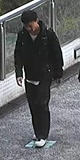
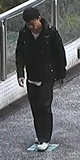
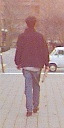
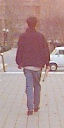
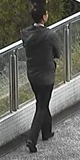
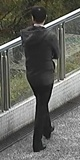

In [26]:
# Explanation: 
# 1. The "labels" column contains labels counts and presence of different counts means those images have different labels. 
# 2. That means the compoments contain badly labeled images or images with different people.
# 3. Column "len" shows number of images per component

result = df\
.query('isBadComponent_std_threshold_30 == 1 and 2 <= len < 20')\
.groupby(['component_id'])\
.agg({'image': lambda x: ListOfImageLoaders(x.sample(min(5, len(x))).values.tolist(), columns_per_row=5),
     'labels':'unique',
     'len':'mean'})\

result.reset_index().sample(10).render()

# Good (clean) images


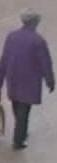
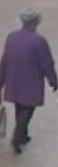
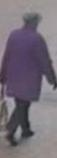
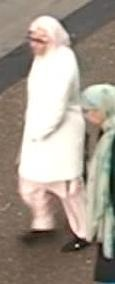
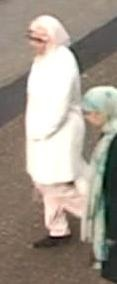
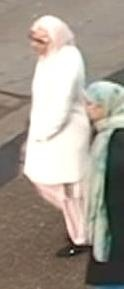
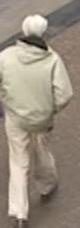
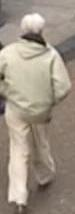
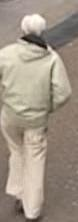
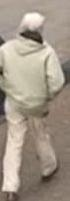
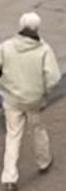
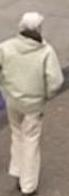
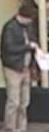
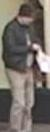
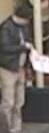
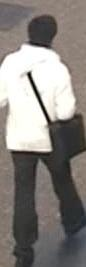
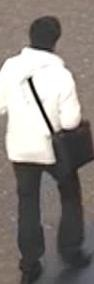
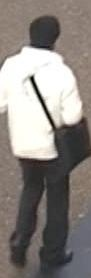
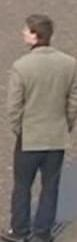
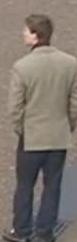
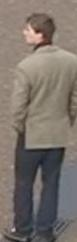
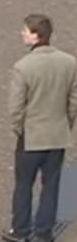
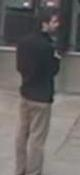
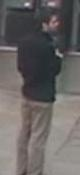
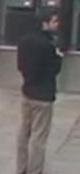
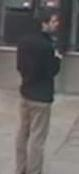
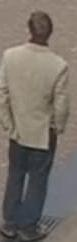
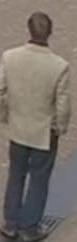
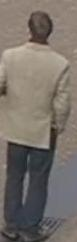
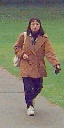
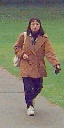
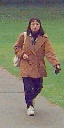

In [27]:
result = df\
.query('isBadComponent_std_threshold_50 == 0 and 2 < len < 5')\
.groupby(['component_id'])\
.agg({'image': lambda x: ListOfImageLoaders(x.sample(min(5, len(x))).values.tolist(), columns_per_row=5),
     'labels':'unique',
     'len':'mean'})\

result.reset_index().sample(10).render()